In [39]:
import pandas as pd
from sklearn.model_selection import train_test_split
from modeling_functions import evaluate_model, plot_features_importance

df = pd.read_parquet('data/2023/for_ml_model.parquet')
df.set_index('Data Godzina', inplace=True)

RANDOM_STATE = 42
TEST_SIZE = 0.3
df_evaluate = pd.DataFrame()

In [40]:
X = df[[
    'Godzinowe zuzycie gd MWh',
    # 'Delta godzinowe zużycie gd MWh',
    'Godzinowe zuzycie krajowe MWh', 
    'Generacja ze źródeł wiatrowych MWh', 
    'Generacja ze źródeł fotowoltaicznych MWh',
    'Temperatura C',
    # 'Święto',
    'Dzień tygodnia',
    'Godzina',
    # 'Miesiąc'
]]

y = df['Cena PLN/MWh']

# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

## 2.1 Random Forest

In [41]:
from sklearn.ensemble import RandomForestRegressor


rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

df_evaluate = evaluate_model(df_evaluate, y_test, y_pred, "Random Forest", with_gd=True)
df_evaluate

,Model,Z gospodarstwami domowymi,R-Squared,Mean Absolute Error (MAE),Root Mean Squared Error (RMSE)
0,Random Forest,True,0.813803,58.453157,76.829316


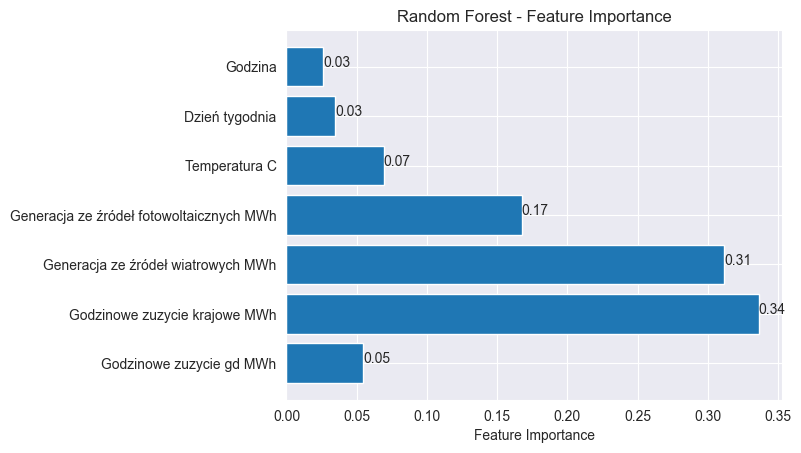

In [43]:
feature_importance = rf.feature_importances_
features = X.columns

plot_features_importance(features, feature_importance, 'Random Forest')

## 2.2 Support Vector Machine (SVM)

### Strojenie hiperparametrów

In [44]:
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

param_grid = {
    # 'svr__C': [
    #     1, 10, 50, 100, 200,
    #     500, 1000, 2000, 5000
    # ],
    'svr__C': [
         800, 
    ],
    'svr__gamma': [0.1, 1, 2, 3, 'scale'],
}
svr = make_pipeline(StandardScaler(), SVR(kernel='rbf'))
grid_search = GridSearchCV(svr, param_grid, cv=3, scoring='r2', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best parameters
print("Best parameters:", grid_search.best_params_)
y_pred = grid_search.predict(X_test)


Best parameters: {'svr__C': 800, 'svr__gamma': 1}


### Cross validation

In [45]:
svr = make_pipeline(StandardScaler(), SVR(kernel='rbf', C=800, gamma=1))
# svr = make_pipeline(StandardScaler(), SVR(kernel='rbf', C=150, gamma=1))
svr.fit(X_train, y_train)
y_pred = svr.predict(X_test)

df_evaluate = evaluate_model(df_evaluate, y_test, y_pred, "Support Vector Machine", with_gd=True)
df_evaluate

,Model,Z gospodarstwami domowymi,R-Squared,Mean Absolute Error (MAE),Root Mean Squared Error (RMSE)
0,Random Forest,True,0.813803,58.453157,76.829316
0,Support Vector Machine,True,0.836217,50.497385,72.056742


## 2.3 Gradient Boosting Machines (GBM)

In [46]:
from xgboost import XGBRegressor

gbm = XGBRegressor(random_state=42)
gbm.fit(X_train, y_train)
y_pred = gbm.predict(X_test)

df_evaluate = evaluate_model(df_evaluate, y_test, y_pred, "Gradient Boosting Machines", with_gd=True)
df_evaluate

,Model,Z gospodarstwami domowymi,R-Squared,Mean Absolute Error (MAE),Root Mean Squared Error (RMSE)
0,Random Forest,True,0.813803,58.453157,76.829316
0,Support Vector Machine,True,0.836217,50.497385,72.056742
0,Gradient Boosting Machines,True,0.811208,58.683913,77.362827


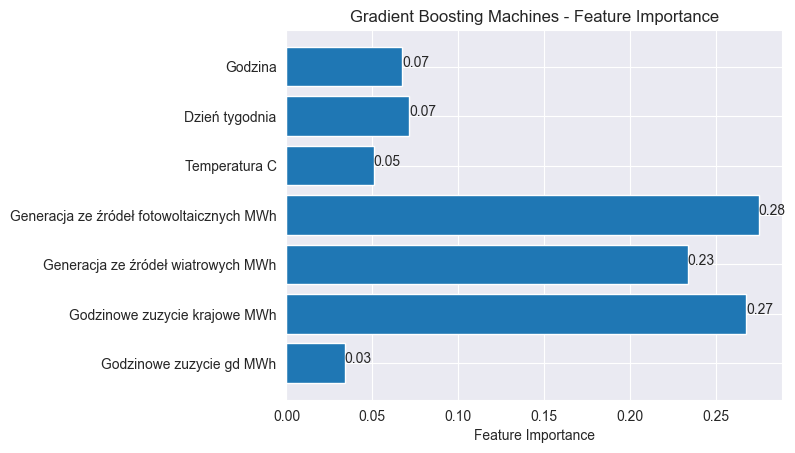

In [47]:
feature_importance = gbm.feature_importances_
features = X.columns

plot_features_importance(features, feature_importance, 'Gradient Boosting Machines')


# Final training

In [49]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from modeling_functions import evaluate_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor


df = pd.read_parquet('data/2023/for_ml_model.parquet')
# df.set_index('Data Godzina', inplace=True)

RANDOM_STATE = 42
TEST_SIZE = 0.3
df_evaluate = pd.DataFrame()


def create_model_random_forest(X_train, y_train):
    # Initialize and train Random Forest models
    rf = RandomForestRegressor(random_state=42)
    # Fit data
    rf.fit(X_train, y_train)

    return rf

def create_model_svm(X_train, y_train):
    # Standardize features and train SVM
    svr = make_pipeline(StandardScaler(), SVR(kernel='rbf', C=800, gamma=1))
    # Fit data
    svr.fit(X_train, y_train)

    return svr

def create_model_gbm(X_train, y_train):
    # Initialize and train Gradient Boosting model
    gbm = XGBRegressor(random_state=42)
    # Fit data
    gbm.fit(X_train, y_train)
    
    return gbm

def train_models_and_compare(df: pd.DataFrame, X_columns: list, with_gd: bool):
    X = df[X_columns].copy()
    y = df['Cena PLN/MWh']
    
    df_evaluate = pd.DataFrame()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)
    
    rf_model = create_model_random_forest(X_train, y_train)
    svm_model = create_model_svm(X_train, y_train)
    gbm_model = create_model_gbm(X_train, y_train)
    
    y_pred_rf = rf_model.predict(X_test)
    y_pred_svm = svm_model.predict(X_test)
    y_pred_gbm = gbm_model.predict(X_test)

    df_evaluate = evaluate_model(df_evaluate, y_test, y_pred_rf, "Random Forest", with_gd)
    df_evaluate = evaluate_model(df_evaluate, y_test, y_pred_svm, "Support Vector Machine", with_gd)
    df_evaluate = evaluate_model(df_evaluate, y_test, y_pred_gbm, "Gradient Boosting Machines", with_gd)
    
    ### Szkolenie na całym zbiorze, tylko do porównania metryk 
    # y_pred_rf = rf_model.predict(X)
    # y_pred_svm = svm_model.predict(X)
    # y_pred_gbm = gbm_model.predict(X)
    # 
    # df_evaluate = evaluate_model(df_evaluate, y, y_pred_rf, "Random Forest", with_gd)
    # df_evaluate = evaluate_model(df_evaluate, y, y_pred_svm, "Support Vector Machine", with_gd)
    # df_evaluate = evaluate_model(df_evaluate, y, y_pred_gbm, "Gradient Boosting Machines", with_gd)
    
    return df_evaluate

In [50]:
X_gd_columns = [
    'Godzinowe zuzycie gd MWh',
    'Godzinowe zuzycie krajowe MWh', 
    'Generacja ze źródeł wiatrowych MWh', 
    'Generacja ze źródeł fotowoltaicznych MWh',
    'Temperatura C',
    'Dzień tygodnia',
    'Godzina',
]

X_no_gd_columns = [
    'Godzinowe zuzycie krajowe MWh', 
    'Generacja ze źródeł wiatrowych MWh', 
    'Generacja ze źródeł fotowoltaicznych MWh',
    'Temperatura C',
    'Dzień tygodnia',
    'Godzina',
]

df_evaluate_no_gd = train_models_and_compare(df, X_no_gd_columns, with_gd=False)
df_evaluate_with_gd = train_models_and_compare(df, X_gd_columns, with_gd=True)


In [51]:
df_result = pd.concat([df_evaluate_no_gd, df_evaluate_with_gd]).reset_index(drop=True).sort_values('Model')
df_result

,Model,Z gospodarstwami domowymi,R-Squared,Mean Absolute Error (MAE),Root Mean Squared Error (RMSE)
2,Gradient Boosting Machines,False,0.792955,61.515002,81.016437
5,Gradient Boosting Machines,True,0.811208,58.683913,77.362827
0,Random Forest,False,0.804848,59.725492,78.655056
3,Random Forest,True,0.813803,58.453157,76.829316
1,Support Vector Machine,False,0.810175,53.992917,77.574230
4,Support Vector Machine,True,0.836217,50.497385,72.056742


### Walidacja krzyżowa najlepszego modelu

In [52]:
from sklearn.model_selection import cross_val_score

y = df['Cena PLN/MWh']
X = df[X_gd_columns]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)


best_svr = make_pipeline(StandardScaler(), SVR(kernel='rbf', C=800, gamma=1))

# Perform 5-fold cross-validation
cv_scores = cross_val_score(best_svr, X_train, y_train, cv=5, scoring='r2', n_jobs=-1)

# Display cross-validation results
print("Cross-validation R^2 scores:", cv_scores)
print("Mean R^2 score:", cv_scores.mean())
print("Standard deviation of R^2 scores:", cv_scores.std())

Cross-validation R^2 scores: [0.82834571 0.83750197 0.83148885 0.83606397 0.8242321 ]
Mean R^2 score: 0.8315265217625365
Standard deviation of R^2 scores: 0.004891258314324354


## Wizualizacja najlepszego modelu

In [ ]:
y = df['Cena PLN/MWh']

X_gd = df[X_gd_columns].copy()
X_train, X_test, y_train, y_test = train_test_split(X_gd, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)
svm_model = create_model_svm(X_train, y_train)
price_predicted = svm_model.predict(X_gd)
df['Cena prognozowana z gd PLN/MWh'] = price_predicted

X_no_gd = df[X_no_gd_columns].copy()
X_train, X_test, y_train, y_test = train_test_split(X_no_gd, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)
svm_model = create_model_svm(X_train, y_train)
price_predicted = svm_model.predict(X_no_gd)
df['Cena prognozowana bez gd PLN/MWh'] = price_predicted


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
# Assuming df is already defined with the required columns
# Plotting a line chart with three different 'Cena' columns

def plot_scores(df):
    plt.figure(figsize=(12, 6))
    linewidth = 2.5
    alpha = 0.6
    plt.plot(df.index, df['Cena PLN/MWh'], label='Cena PLN/MWh', linewidth=linewidth, alpha=alpha)
    plt.plot(df.index, df['Cena prognozowana z gd PLN/MWh'], label='Cena prognozowana z gd PLN/MWh', linewidth=linewidth, alpha=alpha)
    plt.plot(df.index, df['Cena prognozowana bez gd PLN/MWh'], label='Cena prognozowana bez gd PLN/MWh', linewidth=linewidth, alpha=alpha)
    
    # Adding labels and title
    plt.xlabel('Data')
    plt.ylabel('Cena (PLN/MWh)')
    plt.title('Comparison of Different Cena Columns')
    plt.legend()
    plt.grid(True)
    
    plt.show()


### MAE, RSME dla całego zbioru danych (pogrupowanego po dniach)

In [ ]:
import numpy as np

df['Dzień'] = df['Data Godzina'].dt.day
df['Rok'] = df['Data Godzina'].dt.year
df['MAE gd'] = abs(df['Cena PLN/MWh'] - df['Cena prognozowana z gd PLN/MWh'])
df['MAE bez gd'] = abs(df['Cena PLN/MWh'] - df['Cena prognozowana bez gd PLN/MWh'])

df['MSE gd'] = (df['Cena PLN/MWh'] - df['Cena prognozowana z gd PLN/MWh']) ** 2
df['MSE bez gd'] = (df['Cena PLN/MWh'] - df['Cena prognozowana bez gd PLN/MWh']) ** 2


In [ ]:
df_group = df.groupby(['Dzień', 'Miesiąc']).agg({
    'Data Godzina': 'min',
    'MAE gd': 'mean',
    'MAE bez gd': 'mean',
    'MSE gd': 'mean',
    'MSE bez gd': 'mean'
}).reset_index()

# df_group = df.groupby(['Rok']).mean().reset_index()
df_group['RMSE gd'] = np.sqrt(df_group['MSE gd'])
df_group['RMSE bez gd'] = np.sqrt(df_group['MSE bez gd'])
df_group['RMSE porównanie'] = (df_group['RMSE bez gd'] / df_group['RMSE gd'])
df_group

In [ ]:
df_group

In [ ]:
plt.figure(figsize=(12, 6))
sns.lineplot(x=df_group['Data Godzina'].dt.date, y=df_group['RMSE porównanie'])

plt.xlabel('Data')
plt.title('Porównanie RMSE z gd vs RMSE bez gd')
plt.grid(True)

plt.show()

In [ ]:
df_group

In [ ]:
df_holidays = df[df['Święto'] == 1].reset_index().copy()
df_evaluate_holidays = pd.DataFrame()
df_evaluate_holidays = evaluate_model(df_evaluate_holidays, df_holidays['Cena PLN/MWh'], df_holidays['Cena prognozowana z gd PLN/MWh'], 'svm', with_gd=True)
df_evaluate_holidays = evaluate_model(df_evaluate_holidays, df_holidays['Cena PLN/MWh'], df_holidays['Cena prognozowana bez gd PLN/MWh'], 'svm', with_gd=False)
df_evaluate_holidays